# Building Rooftop detection by sam2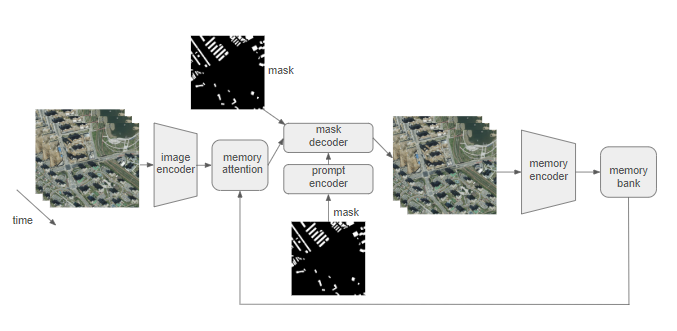



# Installation


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 8.89 MiB/s, done.
Resolving deltas: 100% (376/376), done.


In [ ]:
%cd /content/segment-anything-2

/content/segment-anything-2


In [ ]:
!pip install -e .

Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached

### 어떤 모델 쓸지

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt

--2025-02-15 00:31:49--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323493298 (309M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_base_plus.pt’

sam2_hiera_base_plu 100%[===================>] 308.51M   296MB/s    in 1.0s    

2025-02-15 00:31:50 (296 MB/s) - ‘sam2_hiera_base_plus.pt’ saved [323493298/323493298]



#Download Image

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import shutil
from google.colab import drive
import zipfile
import torch
import cv2
from google.colab.patches import cv2_imshow
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:



def copy_files_and_folders(source_folder, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)
        if os.path.isdir(source_item):
            shutil.copytree(source_item, destination_item, dirs_exist_ok=True)
        else:
            shutil.copy2(source_item, destination_item)

    print(f"All files and folders from '{source_folder}' have been copied to '{destination_folder}'.")

source_folder = '' # 경로 설정
destination_folder = '/content/'
copy_files_and_folders(source_folder, destination_folder)

All files and folders from '/content/drive/MyDrive/final_project/한찬희/load_data/업스케일링 전체/' have been copied to '/content/'.


# preprocess

각각 폴더로 unzip

In [ ]:



def unzip_to_new_folder(zip_filepath, destination_folder):

  if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

  with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
unzip_to_new_folder('mask.zip', '/content/mask')

In [ ]:
unzip_to_new_folder('/content/upscaling-20250210T052213Z-001.zip', '/content/image')
unzip_to_new_folder('/content/upscaling-20250210T052213Z-002.zip', '/content/image')
unzip_to_new_folder('/content/upscaling-20250210T052213Z-003.zip', '/content/image')
unzip_to_new_folder('/content/upscaling-20250210T052213Z-004.zip', '/content/image')
unzip_to_new_folder('/content/upscaling-20250210T052213Z-005.zip', '/content/image')
unzip_to_new_folder('/content/upscaling-20250210T052213Z-006.zip', '/content/image')

필요없는 문자 제거

In [ ]:
image_dir = "/content/image/upscaling"  # 원본 이미지 폴더
mask_dir = "/content/mask/"

In [ ]:
def rename_files(directory,word):
  for filename in os.listdir(directory):
    if word in filename:
      new_filename = filename.replace(word, '')
      os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
      #print(f"Renamed '{filename}' to '{new_filename}'")

# Example usage (replace with your actual directory)
rename_files(image_dir ,"_out")

In [ ]:
image_files = set(os.listdir(image_dir))
for mask_file in os.listdir(mask_dir):
    if mask_file not in image_files:
        mask_path = os.path.join(mask_dir, mask_file)
        os.remove(mask_path)
        print(f"Deleted: {mask_path}")


Deleted: /content/mask/37706024_001_2.png
Deleted: /content/mask/37706034_020_5.png
Deleted: /content/mask/37710070_026_4.png
Deleted: /content/mask/37709050_018_3.png
Deleted: /content/mask/37615029_008_5.png
Deleted: /content/mask/37612059_024_8.png
Deleted: /content/mask/37706024_014_5.png
Deleted: /content/mask/37706032_019_5.png
Deleted: /content/mask/37706042_011_6.png
Deleted: /content/mask/37706033_020_1.png
Deleted: /content/mask/37710069_020_7.png
Deleted: /content/mask/37709050_028_9.png
Deleted: /content/mask/37709059_001_2.png
Deleted: /content/mask/37705057_001_5.png
Deleted: /content/mask/37711063_030_8.png
Deleted: /content/mask/37709040_024_5.png
Deleted: /content/mask/37711091_004_3.png
Deleted: /content/mask/37615020_013_9.png
Deleted: /content/mask/37705038_003_2.png
Deleted: /content/mask/37711071_014_6.png
Deleted: /content/mask/37711093_019_8.png
Deleted: /content/mask/37705058_004_9.png
Deleted: /content/mask/37608042_022_3.png
Deleted: /content/mask/37615029_01

빌딩 없는 이미지 삭제

In [ ]:
import os
import shutil


# 경로 설정 (사용자 환경에 맞게 수정)
image_ext = ".png"                      # 원본 이미지 확장자
mask_ext = ".png"                       # 마스크 이미지 확장자

def is_fully_black(mask_path):
    """마스크가 완전히 검정색인지 확인"""
    img = Image.open(mask_path)
    img_array = np.array(img)
    return np.all(img_array == 0)

# 삭제 대상 파일 수집
empty_masks = []
for mask_name in os.listdir(mask_dir):
    if mask_name.endswith(mask_ext):
        mask_path = os.path.join(mask_dir, mask_name)
        if is_fully_black(mask_path):
            empty_masks.append(mask_name)

# 파일 삭제 실행
deleted_count = 0
for mask_name in empty_masks:
    try:
        # 마스크 파일 삭제
        mask_path = os.path.join(mask_dir, mask_name)
        os.remove(mask_path)
        #print(f"Deleted mask: {mask_path}")

        # 해당 원본 이미지 삭제
        base_name = os.path.splitext(mask_name)[0]
        image_name = base_name + image_ext
        image_path = os.path.join(image_dir, image_name)

        if os.path.exists(image_path):
            os.remove(image_path)
            #print(f"Deleted image: {image_path}")
            deleted_count += 1
        else:
            print(f"Image not found: {image_path}")

    except Exception as e:
        print(f"Error deleting {mask_name}: {str(e)}")

print(f"\nTotal deleted pairs: {deleted_count}/{len(empty_masks)}")


Total deleted pairs: 2915/2915


In [ ]:
import os

def count_files(image_dir, mask_dir, image_ext=".png", mask_ext=".png"):
    """두 폴더의 파일 개수를 세는 함수"""
    # 원본 이미지 개수 세기
    image_count = len([
        f for f in os.listdir(image_dir)
        if f.endswith(image_ext)
    ])

    # 마스크 이미지 개수 세기
    mask_count = len([
        f for f in os.listdir(mask_dir)
        if f.endswith(mask_ext)
    ])

    return image_count, mask_count


img_cnt, msk_cnt = count_files(image_dir, mask_dir)
print(f"원본 이미지: {img_cnt}개, 마스크 이미지: {msk_cnt}개")

원본 이미지: 20114개, 마스크 이미지: 20114개


# Training Preparation

테스트 데이터 확보

In [ ]:
import os
import shutil

def move_top_files(source_folder, destination_folder, num_files=20):
    # 대상 폴더가 없으면 생성
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # 원본 폴더 내의 파일 목록을 이름 순으로 정렬
    files = sorted(os.listdir(source_folder))

    # 상위 num_files개 파일 선택
    files_to_move = files[:num_files]

    # 선택된 파일을 대상 폴더로 이동
    for file_name in files_to_move:
        source_file = os.path.join(source_folder, file_name)
        destination_file = os.path.join(destination_folder, file_name)
        shutil.move(source_file, destination_file)

    print('파일 이동 완료.')

test_num = img_cnt//10
move_top_files('/content/image/upscaling', '/content/image_test/', test_num)
move_top_files('/content/mask/', '/content/mask_test/', test_num)


파일 이동 완료.
파일 이동 완료.


In [ ]:
def get_image_annotation_pairs(image_dir, annotation_dir, image_ext=".png", annotation_ext=".png"):
    data = []  # 이미지 및 어노테이션 파일 목록을 저장할 리스트

    # 'image' 폴더 내의 모든 파일을 순회
    for image_name in os.listdir(image_dir):
        # 파일이 지정된 이미지 확장자로 끝나는지 확인
        if image_name.endswith(image_ext):
            # 이미지 경로 생성
            image_path = os.path.join(image_dir, image_name)

            # 어노테이션 파일 이름 생성 (이미지 파일 이름에서 확장자 제거 후 어노테이션 확장자 추가)
            annotation_name = os.path.splitext(image_name)[0] + annotation_ext
            annotation_path = os.path.join(annotation_dir, annotation_name)

            # 어노테이션 파일이 존재하는지 확인
            if os.path.exists(annotation_path):
                # 데이터 리스트에 딕셔너리로 저장
                data.append({"image": image_path, "annotation": annotation_path})
            else:
                print(f"Warning: 어노테이션 파일 {annotation_path}가 존재하지 않습니다.")

    return data


# 함수 호출
data = get_image_annotation_pairs(image_dir, mask_dir)

# 결과 출력
print(data)

[{'image': '/content/image/upscaling/37709060_036_8.png', 'annotation': '/content/mask/37709060_036_8.png'}, {'image': '/content/image/upscaling/37711092_005_2.png', 'annotation': '/content/mask/37711092_005_2.png'}, {'image': '/content/image/upscaling/37710041_007_3.png', 'annotation': '/content/mask/37710041_007_3.png'}, {'image': '/content/image/upscaling/37710079_019_7.png', 'annotation': '/content/mask/37710079_019_7.png'}, {'image': '/content/image/upscaling/37615019_034_7.png', 'annotation': '/content/mask/37615019_034_7.png'}, {'image': '/content/image/upscaling/37615028_028_2.png', 'annotation': '/content/mask/37615028_028_2.png'}, {'image': '/content/image/upscaling/37701083_022_5.png', 'annotation': '/content/mask/37701083_022_5.png'}, {'image': '/content/image/upscaling/37701093_002_9.png', 'annotation': '/content/mask/37701093_002_9.png'}, {'image': '/content/image/upscaling/37709050_021_8.png', 'annotation': '/content/mask/37709050_021_8.png'}, {'image': '/content/image/u

In [ ]:
img_cnt, msk_cnt = count_files(image_dir, mask_dir)
print(f"원본 이미지: {img_cnt}개, 마스크 이미지: {msk_cnt}개")

원본 이미지: 18103개, 마스크 이미지: 18103개


In [ ]:
len(data)

18103

In [ ]:
import numpy as np
import cv2

def read_batch(data, batch_size=4):
    """Read a batch of images and their corresponding annotations."""
    batch_entries = np.random.choice(data, batch_size, replace=False)
    images, masks, points, labels = [], [], [], []

    for entry in batch_entries:
        # 이미지 읽기
        image = cv2.imread(entry["image"])


        # 어노테이션 맵 읽기
        ann_map = cv2.imread(entry["annotation"])

        # 이미지와 어노테이션 맵 크기 조정 (필요한 경우)
        r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
        # 아래 두 줄은 주석 처리되어 있지만, 필요하다면 주석을 해제하고 사용할 수 있습니다.
        # image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))
        # ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

        # 어노테이션 맵 처리
        mat_map = ann_map[:, :, 0].astype(np.int64)
        ves_map = ann_map[:, :, 2].astype(np.int64)
        mat_map[mat_map == 0] = ves_map[mat_map == 0] * (mat_map.max() + 1)

        inds = np.unique(mat_map)[1:]
        image_masks, image_points = [], []
        for ind in inds:
            mask = (mat_map == ind).astype(np.uint8)
            image_masks.append(mask)
            coords = np.argwhere(mask > 0)
            random_coord = np.array(coords[np.random.randint(len(coords))])
            image_points.append([[random_coord[1], random_coord[0]]])

        images.append(image)
        masks.append(np.array(image_masks))
        points.append(np.array(image_points))
        labels.append(np.ones([len(image_masks), 1]))

    return images, masks, points, labels


In [ ]:
sam2_checkpoint = "sam2_hiera_base_plus.pt" # path to model weight
model_cfg = "sam2_hiera_b+.yaml" # model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model) # load net

In [ ]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
predictor.model.image_encoder.train(True) # enable training of image encoder

ImageEncoder(
  (trunk): Hiera(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 112, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    )
    (blocks): ModuleList(
      (0-1): 2 x MultiScaleBlock(
        (norm1): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
        (attn): MultiScaleAttention(
          (qkv): Linear(in_features=112, out_features=336, bias=True)
          (proj): Linear(in_features=112, out_features=112, bias=True)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (layers): ModuleList(
            (0): Linear(in_features=112, out_features=448, bias=True)
            (1): Linear(in_features=448, out_features=112, bias=True)
          )
          (act): GELU(approximate='none')
        )
      )
      (2): MultiScaleBlock(
        (norm1): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), paddi

# Training Loop

In [ ]:
step = len(data)//4
lr = 1e-4
weight_decay=4e-5
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=lr,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler() # set mixed precision
best_iou = 0.0
batch_size = 4
epochs = 2
log_file = 'training_log.txt'
mean_iou = 0

In [ ]:


for epoch in range(epochs):
    for itr in range(step):
        with torch.cuda.amp.autocast():
            images, masks, input_points, input_labels = read_batch(data, batch_size)

            batch_loss = 0
            batch_iou = 0
            valid_batches = 0  # Track valid mask batches

            for i in range(batch_size):
                if masks[i].shape[0] == 0:
                    continue

                predictor.set_image(images[i])

                mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                    input_points[i], input_labels[i], box=None, mask_logits=None, normalize_coords=True
                )
                sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                    points=None, boxes=None, masks=mask_input,
                )

                high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
                low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=True,
                    repeat_image=True,
                    high_res_features=high_res_features,
                )
                prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

                gt_mask = torch.tensor(masks[i].astype(np.float32)).cuda()

                prd_mask_raw = prd_masks[:, 0]  # decoder 출력 값 확인
                print(f"Raw mask stats: Min={prd_mask_raw.min().item()}, Max={prd_mask_raw.max().item()}")
                prd_mask = torch.sigmoid(prd_mask_raw)

                seg_loss = (-gt_mask * torch.log(prd_mask + 1e-5) - (1 - gt_mask) * torch.log(1 - prd_mask + 1e-5)).mean()

                inter = (gt_mask * (prd_mask > 0.5)).sum(dim=[1, 2])
                iou = inter / (gt_mask.sum(dim=[1, 2]) + (prd_mask > 0.5).sum(dim=[1, 2]) - inter)
                score_loss = torch.abs(prd_scores[:, 0] - iou).mean()

                loss = seg_loss + score_loss * 0.05
                batch_loss += loss
                batch_iou += torch.mean(iou).item()
                valid_batches += 1

            if valid_batches == 0:
                continue

            batch_loss /= valid_batches
            batch_iou /= valid_batches

            predictor.model.zero_grad()
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            mean_iou = mean_iou * 0.99 + 0.01 * batch_iou

            if mean_iou > best_iou:
                best_iou = mean_iou
                torch.save(predictor.model.state_dict(), "model_best.torch")

            # 학습 종료 시 최종 모델 저장
            if epoch == epochs - 1 and itr == step - 1:
                torch.save(predictor.model.state_dict(), "model_final.torch")

            log_entry = f"Epoch {epoch}, Step {itr}, Accuracy (IoU) = {mean_iou:.4f}\n"

            # 로그를 추가 모드로 저장
            with open(log_file, 'a') as log:
                log.write(log_entry)

            print(log_entry.strip())


<ipython-input-22-c0f1bc15a1ef>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Raw mask stats: Min=-15.6064453125, Max=9.788330078125
Raw mask stats: Min=-14.564453125, Max=4.75390625
Raw mask stats: Min=-17.623046875, Max=8.338623046875
Raw mask stats: Min=-18.01123046875, Max=0.79986572265625
Epoch 1, Step 3525, Accuracy (IoU) = 0.6110
Raw mask stats: Min=-14.5927734375, Max=5.971923828125
Raw mask stats: Min=-13.38134765625, Max=10.55419921875
Raw mask stats: Min=-14.2607421875, Max=11.2744140625
Raw mask stats: Min=-16.4873046875, Max=5.5986328125
Epoch 1, Step 3526, Accuracy (IoU) = 0.6112
Raw mask stats: Min=-21.3291015625, Max=10.23828125
Raw mask stats: Min=-15.3857421875, Max=10.34423828125
Raw mask stats: Min=-14.45166015625, Max=2.20489501953125
Raw mask stats: Min=-17.919921875, Max=8.1728515625
Epoch 1, Step 3527, Accuracy (IoU) = 0.6121
Raw mask stats: Min=-14.26025390625, Max=2.849365234375
Raw mask stats: Min=-16.9658203125, Max=4.6748046875
Raw mask stats: Min=-19.9833984375, Max=5.0537109375
Raw mask stats: Mi

# test

예측마스크 저장

In [ ]:


# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("model_final.torch"))

# 이미지 폴더, 마스크 폴더, 예측 마스크 저장 폴더 경로 설정
image_folder = "/content/image_test"
mask_folder = "/content/mask_test"
prediction_folder = "/content/prediction3"
# 예측 마스크 저장 폴더가 없으면 생성
os.makedirs(prediction_folder, exist_ok=True)

# 이미지 폴더에서 모든 이미지 파일을 읽음
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

# 예측 마스크 저장 함수 (label 1만 저장)
def save_predicted_masks_label1(image_files, image_folder, prediction_folder):
    for image_file in image_files:
        # 이미지 파일 경로
        image_path = os.path.join(image_folder, image_file)

        # 예측 마스크 저장 경로
        prediction_path = os.path.join(prediction_folder, image_file.replace('.jpg', '.png').replace('.jpeg', '.png'))

        # 이미지 읽기
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 모델로 마스크 예측
        with torch.no_grad():
            predictor.set_image(image)
            masks, scores, logits = predictor.predict()

        # label 1에 해당하는 마스크만 선택
        label1_mask = None
        for mask in masks:
            if np.any(mask == 1):  # label 1에 해당하는 마스크인지 확인
                label1_mask = (mask == 1).astype(np.uint8) * 255  # label 1을 하얀색(255)으로 채움
                break

        # label 1 마스크가 없으면 빈 마스크 생성
        if label1_mask is None:
            label1_mask = np.zeros_like(masks[0], dtype=np.uint8)

        # 예측 마스크 저장
        cv2.imwrite(prediction_path, label1_mask)

# 예측 마스크 저장 (label 1만 저장)
save_predicted_masks_label1(image_files, image_folder, prediction_folder)

<ipython-input-24-82dcda8dd58c>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load("model_final.torch"))


후처리

In [ ]:
import os
import cv2
import numpy as np


# 결과 저장 폴더 생성
opened_folder = os.path.join(prediction_folder, "opened")
closed_folder = os.path.join(prediction_folder, "closed")
opened_closed_folder = os.path.join(prediction_folder, "opened_closed")

os.makedirs(opened_folder, exist_ok=True)
os.makedirs(closed_folder, exist_ok=True)
os.makedirs(opened_closed_folder, exist_ok=True)

# 커널 정의 (5x5 원형 커널)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# 예측 마스크 폴더에서 모든 이미지 파일 읽기
mask_files = [f for f in os.listdir(prediction_folder) if f.endswith(('.png', '.jpg'))]

for mask_file in mask_files:
    # 마스크 파일 경로
    mask_path = os.path.join(prediction_folder, mask_file)

    # 마스크 이미지 읽기 (이진 이미지)
    binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 열기(Opening) 적용: 침식 → 팽창
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel,iterations=3)

    # 닫기(Closing) 적용: 팽창 → 침식
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel,iterations=3)

    # 열기 후 닫기 적용
    opened_closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel,iterations=3)

    # 결과 저장
    opened_path = os.path.join(opened_folder, f"{mask_file}")
    closed_path = os.path.join(closed_folder, f"{mask_file}")
    opened_closed_path = os.path.join(opened_closed_folder, f"{mask_file}")

    cv2.imwrite(opened_path, opened_mask)
    cv2.imwrite(closed_path, closed_mask)
    cv2.imwrite(opened_closed_path, opened_closed_mask)

print("모든 마스크에 형태학적 연산이 적용되었습니다!")

지표계산

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed


# 1. 지표를 직접 계산하는 함수 (sklearn 호출 대신)

def compute_metrics(gt_mask, pred_mask):
    # 이진화: 0은 배경, 1은 객체
    gt_bin = (gt_mask > 0).astype(np.uint8)
    pred_bin = (pred_mask > 0).astype(np.uint8)
    gt_flat = gt_bin.flatten()
    pred_flat = pred_bin.flatten()
    total_pixels = len(gt_flat)

    # 1. Pixel Accuracy
    pa = np.sum(gt_flat == pred_flat) / total_pixels

    # 2. Mean Pixel Accuracy
    # (원래 코드에서는 각 클래스에 대해 (전체 픽셀에서 맞춘 비율)을 평균내었음)
    mpa_0 = np.sum((gt_flat == 0) == (pred_flat == 0)) / total_pixels
    mpa_1 = np.sum((gt_flat == 1) == (pred_flat == 1)) / total_pixels
    mpa = (mpa_0 + mpa_1) / 2

    # 3. IoU (클래스 1에 대한 IoU)
    intersection = np.sum((gt_flat == 1) & (pred_flat == 1))
    union = np.sum((gt_flat == 1) | (pred_flat == 1))
    iou = intersection / union if union > 0 else 1

    # 4. Mean IoU (클래스별 IoU의 평균)
    # 클래스 0:
    intersection0 = np.sum((gt_flat == 0) & (pred_flat == 0))
    union0 = np.sum((gt_flat == 0) | (pred_flat == 0))
    iou0 = intersection0 / union0 if union0 > 0 else 1
    # 클래스 1: 이미 계산함(iou)
    miou = (iou0 + iou) / 2

    # 5. Dice Coefficient (F1 Score와 동일)
    tp = intersection
    fp = np.sum(pred_flat == 1) - tp
    fn = np.sum(gt_flat == 1) - tp
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 1
    f1 = dice

    # 6. Pixel Difference (GT와 예측이 다른 픽셀 수)
    diff = np.sum(gt_flat != pred_flat)

    # 7. Success Rate (정답 마스크의 양성 픽셀 중 예측이 양성인 비율, %)
    total_positive = np.sum(gt_flat == 1)
    success_rate = (intersection / total_positive * 100) if total_positive > 0 else 0

    return pa, mpa, iou, miou, dice, f1, diff, success_rate


# 2. 단일 이미지 평가 (병렬 처리 대상)

def evaluate_single_image(image_file, gt_mask, pred_folder):
    pred_path = os.path.join(pred_folder, image_file)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if pred_mask is None:
        # 예측 이미지를 읽지 못한 경우 건너뜁니다.
        return None
    return compute_metrics(gt_mask, pred_mask)


# 3. 예측 폴더 내 전체 이미지 평가

def evaluate_prediction_folder(image_files, gt_masks, pred_folder):
    metrics_list = []
    with ThreadPoolExecutor() as executor:
        # image_files 중 GT가 로딩된 파일만 처리합니다.
        futures = {
            executor.submit(evaluate_single_image, image_file, gt_masks[image_file], pred_folder): image_file
            for image_file in image_files if image_file in gt_masks
        }
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                metrics_list.append(result)

    if not metrics_list:
        return None  # 해당 폴더에서 평가된 이미지가 하나도 없으면

    # metrics_list는 각 이미지당 8개 지표를 담은 튜플들의 리스트
    metrics_array = np.array(metrics_list)  # shape: (num_images, 8)
    mean_metrics = np.mean(metrics_array, axis=0)
    return {
        'Mean Pixel Accuracy': mean_metrics[0],
        'Mean Mean Pixel Accuracy': mean_metrics[1],
        'Mean IoU': mean_metrics[2],
        'Mean Mean IoU': mean_metrics[3],
        'Mean Dice Coefficient': mean_metrics[4],
        'Mean F1 Score': mean_metrics[5],
        'Mean Pixel Difference': mean_metrics[6],
        'Mean Success Rate': mean_metrics[7]
    }


# 4. 전체 평가 (Ground Truth는 한 번만 로딩)

def evaluate_all_folders(image_files, mask_folder, pred_folders):
    # GT 이미지를 미리 로딩하여 캐싱 (파일이 많더라도 메모리에 부담이 없다면)
    gt_masks = {}
    for image_file in image_files:
        mask_path = os.path.join(mask_folder, image_file)
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is not None:
            gt_masks[image_file] = gt_mask

    results = {}
    for folder in pred_folders:
        folder_name = os.path.basename(os.path.normpath(folder))
        print(f"Evaluating folder: {folder_name}")
        folder_metrics = evaluate_prediction_folder(image_files, gt_masks, folder)
        if folder_metrics is not None:
            results[folder_name] = folder_metrics
        else:
            results[folder_name] = {}  # 해당 폴더에서 평가된 이미지가 없는 경우
    return results


# 5. 결과를 CSV로 저장하는 함수

def save_results_to_csv(results, output_path="evaluation_final.csv"):
    df = pd.DataFrame(results).T.reset_index()
    df.columns = ['Folder'] + list(next(iter(results.values())).keys())

    # 소수점 4자리까지 반올림
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].round(4)

    df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"결과가 '{output_path}' 파일로 저장되었습니다.")


# 6. 실행 파라미터 및 평가 실행

      pred_folders = [
          "/content/prediction",
          "/content/prediction/opened",
          "/content/prediction/closed",
          "/content/prediction/opened_closed"
      ]


      # 전체 평가 수행 및 CSV 저장
      results = evaluate_all_folders(image_files, mask_folder, pred_folders)
      save_results_to_csv(results)


# Restore tiling to its original state

In [ ]:
import os
import numpy as np
import cv2

def reconstruct_from_tiles(tiles, stride, tile_size, img_size):
    img_h, img_w = img_size
    tile_h, tile_w = tile_size
    stride_h, stride_w = stride

    reconstructed = np.zeros((img_h, img_w), dtype=np.uint8)

    num_tiles_h = (img_h - tile_h) // stride_h + 1
    num_tiles_w = (img_w - tile_w) // stride_w + 1

    for i in range(num_tiles_h):
        for j in range(num_tiles_w):
            start_h = i * stride_h
            start_w = j * stride_w
            reconstructed[start_h:start_h+tile_h, start_w:start_w+tile_w] = np.maximum(
                reconstructed[start_h:start_h+tile_h, start_w:start_w+tile_w],
                tiles[i, j]
            )
    return reconstructed

def process_images(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    files = sorted([f for f in os.listdir(input_folder) if f.endswith('.png')])
    grouped_files = {}

    for file in files:
        parts = file.split('_')
        if len(parts) < 2:
            continue
        base_name = parts[0]  # 이미지 넘버 (최대 네 자리)
        tile_number = int(parts[1])  # 타일링 넘버 (1~9)

        if base_name not in grouped_files:
            grouped_files[base_name] = {}
        grouped_files[base_name][tile_number] = file

    for base_name, file_dict in grouped_files.items():
        missing_indices = set(range(1, 10)) - set(file_dict.keys())  # 빠진 번호 찾기
        if len(file_dict) + len(missing_indices) < 9:
            continue  # 배경(검정)으로 판단하고 무시

        tiles = np.zeros((3, 3, 512, 512), dtype=np.uint8)

        for i in range(1, 10):
            row, col = divmod(i - 1, 3)
            if i in missing_indices:
                tiles[row, col] = np.zeros((512, 512), dtype=np.uint8)  # 검정 배경
            else:
                file = file_dict[i]
                img = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_GRAYSCALE)
                tiles[row, col] = img

        reconstructed_image = reconstruct_from_tiles(tiles, stride=(256, 256), tile_size=(512, 512), img_size=(1024, 1024))
        cv2.imwrite(os.path.join(output_folder, f'{base_name}.png'), reconstructed_image)

input_folder = '/content/prediction5/opened_closed'  # 타일 이미지 폴더 경로
output_folder = '/content/prediction_full2'  # 복원된 원본 저장 폴더
process_images(input_folder, output_folder)


노이즈 제거

In [ ]:
def contour_based_filtering(mask, min_area=120):
    # Contour 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 새로운 마스크 생성
    filtered = np.zeros_like(mask)

    # 각 contour에 대해 면적 확인 및 필터링
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            cv2.drawContours(filtered, [contour], 0, 255, -1)

    return filtered

# 처리할 이미지가 있는 디렉토리 경로
input_directory = '/content/mask1/content/prediction_full2'
# 결과를 저장할 디렉토리 경로
output_directory = '/content/mask_pr'

# 출력 디렉토리가 없으면 생성
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 지원하는 이미지 파일 확장자
valid_extensions = '.png'

# 디렉토리 내의 모든 파일에 대해 처리
for filename in os.listdir(input_directory):
    # 파일 확장자 확인
    if any(filename.lower().endswith(ext) for ext in valid_extensions):
        # 전체 파일 경로
        file_path = os.path.join(input_directory, filename)

        # 이미지 읽기
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Contour 기반 필터링 적용
        filtered_mask = contour_based_filtering(mask, min_area=120)

        # 결과 저장
        output_path = os.path.join(output_directory, f'{filename}')
        cv2.imwrite(output_path, filtered_mask)

        print(f'Processed: {filename}')

print("All images have been processed.")